# Physics 210 Project 1: "How can colliding with the slime planet save the spaceship from a black hole?"

**Name:** Mufaro Joseph Machaya

## Introduction

**Context:** Given a three-body system containing a black hole (with a mass $M$), a small planet made of JELL-O-like slime (with mass $m_p$), and a spaceship (with mass $m_s$) accidentally headed directly for the black hole, the only way for the spaceship to avoid being sucked into the black hole is to turn into and collide (inelastically) with the planet such that it is successfully rebounded with a velocity high enough to escape the gravitational pull of the black hole. However, if it hits the planet with too much impulse during the collision, it'll be destroyed by the planet (it's made out of JELL-O, so it has surface tension). 

**Research Question:** *With what range of initial velocities and what turn radius/time allow the ship to successfully avoid being sucked into the black hole without being destroyed by the planet?*

### Physics Model and Assumptions

**Model**

1. $n$-Body System, Gravitational Vector Field

Each of the three objects are modeled individually as point-masses. Each object produces gravitational effects on all other objects by formula

$${\bf F}_g = G \frac{m_1 m_2}{|{\bf r}|^2} \hat{r}.$$

From there, basic kinematic equations apply:

$$\frac{d^2 \bf{x}}{dt^2} = \frac{\sum \bf F}{m}.$$

The system is modeled in only two dimensions rather than three (but all equations apply for each dimension)

2. Spaceship Turning

The ship will need to perform a turn of angle $\theta$ to have a proper head-on collision. This will require the ship to apply thrust to perform the turn, but this turn will require a certain amount of energy. Let's assume that the ship starts with a certain amount of fuel on board (but it will require fuel to accelerate/deccelerate during its journey).

The ship turns with thrust

$${\bf T} = {\bf v} \frac{dm}{dt}$$

3. Inelastic Jello Collision

The force from interacting with a gel-like substance will be modeled using a hunt-crossley algorithm with optional adhesion and a plastic offset, i.e.,

- Contact when the overlap distance $\delta > 0$, and the force for each frame is $$F_N = k \delta^n + \alpha \delta^n \frac{d \delta}{dt},$$ with $n=\frac{3}{2}$ for spherical geometry (and $\delta = R_1 + R_2 - |\vec{r}_1 - \vec{r}_2|$)

4. Propagation by Fuel

The ship requires fuel to run.

**Additional Physics**

This system includes an inelastic collision, a gravitational vector field, and thrust equations. 

**Assumptions**

1. $m_s < m_p <<< M$: The mass of the black hole is so much larger than the mass of the planet and ship that the black hole is taken to be stationary.
2. This model assumes no relativistic effects whatsoever (due to all speeds $v$ being much lower than the speed of light $c$.
3. The ship is presumed to instantaneously make a full $180^\circ$ turn immediately after its collision.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from copy import deepcopy

**Code Block Summary:** This code block implements in the rigid and soft bodies used for simulation. `RigidBody`-ies come with an assumption of being a point-mass, so they don't hold a radius (or any other size), but they're the base object in this simulation, with tracker arrays for each of various simulation variables tied to the object (like position, velocity, acceleration, and whatnot).

In [ ]:
@dataclass
class RigidBody:
    initial_position:     float = 0
    initial_velocity:     float = 0
    initial_acceleration: float = 0
    
    mass:  float = 1
    color: str   = None
    name:  str   = None

    stationary: bool = False 
    
    position:     np.array = None
    velocity:     np.array = None
    acceleration: np.array = None
    energy:       np.array = None
    momentum:     np.array = None
    
    def init(self, n):
        self.position     = np.zeros(n)
        self.velocity     = np.zeros(n)
        self.acceleration = np.zeros(n)
        self.energy       = np.zeros(n)
        self.momentum     = np.zeros(n)
        
        self.position[0]     = self.initial_position
        self.velocity[0]     = self.initial_velocity
        self.acceleration[0] = self.initial_acceleration
        
    def __hash__(self):
        return hash(self.name)
        
    def distance_vec(self, other_body, i):
        return self.position[i] - other_body.position[i]

    def collided_with(self, other_body, collision_radius, i):
        return np.linalg.norm(self.distance_vec(other_body, i)) <= collision_radius
    
    def near_barrier(self, bottom_barrier, top_barrier, collision_radius, i):
        return \
            abs(self.position[i] - bottom_barrier) <= collision_radius or \
            abs(self.position[i] - top_barrier) <= collision_radius
    
@dataclass
class Spaceship(RigidBody):
    remaining_fuel_mass: float
    
@dataclass
class SoftBody(RigidBody):
    radius:          float = 0
    stiffness:       float = 0
    growth_exponent: float = 0
    damping_coeff:   float = 0

**Code Block Summary:** This is where the thrust calculations come in. The space ship has a certain amount of fuel, `remaining_fuel_mass`, in kilograms of burnable fuel (which is approximately reliably converted into energy at a set rate). The instantaneous thrust force produced is
$${\bf F}_{thrust}(t) = T(t) \hat{\bf u}(t),$$
where $T(t)$ is the magnitude of thrust at $t$ and $\hat{\bf u}(t)$ is the direction of thrust. The magnitude of thrust for a given $t$ is
$$T(t) = | \frac{dm}{dt}_{fuel}(t) | {\bf v}_{ex},$$
where ${\bf v}_ex$ is the exhaust velocity given by
$${\bf v}_{ex} = I_{sp} g_0$$
where $I_sp$ is the specific impulse [1](https://en.wikipedia.org/wiki/Specific_impulse) and $g_0$ is the standard gravity [2](https://en.wikipedia.org/wiki/Standard_gravity).

In [ ]:
def calculate_thrust(ship, dt):
    ship.thrust_dir = ship.thust_dir / np.lingalg.norm(ship.thrust_dir)
    thrust_mag = np.max(0, body.desired_thrust_mag)
    
    if thrust_mag <= 0:
        return np.zeros_like(body.thrust_dir), 0.0
    
    exhaust_velocity = specific_impulse

**Code Block Summary:** This is where the net force calculation occurs, from each `body` to all other bodies in the simulation. This is calculated by first determining the amount gravity with
$$\sum {\bf F}_g = m \sum G \frac{m_o}{|{\bf r}|^2} \hat{r}$$
for each object with mass $m$ to each other object with mass $o$, given a radial distance $\bf r$ between them. Then, there's the additional consideration of normal force during the inelastic collision between the spaceship and the slime planet (in the case that it happens) by equation
$$F_N = k \delta^n + \alpha \delta^n \frac{d \delta}{dt},$$ with $n=\frac{3}{2}$ for spherical geometry (and $\delta = R_1 + R_2 - |\vec{r}_1 - \vec{r}_2|$).

In [ ]:
GRAVITATIONAL_CONSTANT = 6.6743e-11

def calculate_net_force(i, body, objects, dt):
    if body.stationary:
        return
    
    other_objects = [x for x in objects if x is not body]
    
    vshape = np.shape(body.acceleration[i - 1])
    
    total_force = np.zeroes(vshape)
    
    gravitational_force = np.zeros(vshape)
    normal_force = np.zeros(vshape)
    
    for other in other_objects:
        displacement = self.distance_vec(other, i - 1)
        distance     = np.linalg.norm(radius)
        direction    = displacement / distance
        
        gravitational_force = gravitational_force + \
            (GRAVITATIONAL_CONSTANT * body.mass * \
             other.mass * direction) / distance ** 2
        total_force += gravitational_force
        
        if isinstance(other, SoftBody) and self.collided_with(other):
            # assume this object has 0 radius because
            # of pointlike approximations
            delta = other.radius - distance
            if delta > 0:
                relative_velocity = body.velocity[i-1] - other.velocity[i-1]
                delta_deriv = -np.dot(relative_velocity, direction)
                normal_force_mag = other.stiffness * delta ** other.growth_exponent + \ 
                    other.damping_coeff * delta ** other.growth_exponent * delta_deriv
                
                normal_force += normal_force_mag * direction
                total_force += normal_force
        
    if isinstance(body, Spaceship):
        ship = body
        thrust_force, fuel_used = calculate_thrust(ship, dt)
        ship.fuel -= fuel_used
        total_force += thrust_force
        
    return total_force

In [ ]:
def simulate(objects, time_range, dt, 
             collision_radius=0.1, 
             bottom_barrier=-10, 
             top_barrier=10):
    time = np.arange(time_range[0], time_range[1], dt)
    total_frames = np.size(time)
    collisions = set()
    
    for body in objects:
        body.init(total_frames)
    
    for i in range(1, total_frames):
        # update positions
        for body in objects:
            if body.stationary is True:
                continue
            
            body.position[i] = body.position[i-1] + body.velocity[i-1]     * dt
            body.velocity[i] = body.velocity[i-1] + body.acceleration[i-1] * dt
            body.acceleration[i] = calculate_acceleration(i, body, objects)
        
        # detect collisions
        to_invert = set()
        
        for first_body_idx, body in enumerate(objects):
            for other_body in objects[first_body_idx+1:]:
                if body.collided_with(other_body, collision_radius, i):
                    collisions.add((time[i], body.position[i]))
                    to_invert.add(body)
                    to_invert.add(other_body)
                    
        for body in objects:
            if body.near_barrier(bottom_barrier, top_barrier, collision_radius, i):
                to_invert.add(body)
        
        for body in to_invert:
            body.velocity[i] *= -1
            
    # ending calculations
    for body in objects:
        body.momentum = body.mass * abs(body.velocity)
        body.energy = (1/2) * body.mass * body.velocity ** 2
        
    # transpose collisions
    collisions = np.array(list(zip(*collisions)))
        
    return time, collisions

**Code Block Summary:** This block plots all of the results 

In [ ]:
def plot_results(objects, time, collisions):
    fig, axs = plt.subplots(4,1, sharex=True, figsize=(8,8))

    # position
    for body in objects:
        axs[0].plot(time, body.position, 
                    color=body.color, 
                    label=body.name,
                    linestyle='dashed')
    axs[0].scatter(collisions[0], collisions[1], label='Collisions')
    axs[0].axhline(y=10, color='black', label='Top Barrier')
    axs[0].axhline(y=-10, color='black', label='Bottom Barrier')
    axs[0].set_ylabel('Position\n(m)')
    axs[0].set_title('Position vs. Time')
    axs[0].legend()

    # velocity
    for body in objects:
        axs[1].plot(time, body.velocity, 
                    color=body.color, 
                    label=body.name)
    axs[1].set_ylabel('Velocity\n(m/s)')
    axs[1].set_title('Velocity vs. Time')
    axs[1].legend()

    # kinetic energy
    total_energy = np.zeros_like(time)
    for body in objects:
        axs[2].plot(time, body.energy * 1e3, 
                    color=body.color, 
                    label=body.name)
        total_energy = total_energy + body.energy
    axs[2].plot(time, total_energy * 1e3, color='green', label='Total Kinetic Energy')
    axs[2].set_ylabel('Kinetic Energy\n(mJ)')
    axs[2].set_title('Kinetic Energy vs. Time')
    axs[2].legend()

    # momentum
    total_momentum = np.zeros_like(time)
    for body in objects:
        axs[3].plot(time, body.momentum * 1e2, 
                    color=body.color, 
                    label=body.name)
        total_momentum = total_momentum + body.momentum
    axs[3].plot(time, total_momentum * 1e2, color='green', label='Total Momentum')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Momentum\n(kg*m/s*10^2)')
    axs[3].set_title('Momentum vs. Time')
    axs[3].legend()

    plt.show()

**Code Block Summary**

In [ ]:
def simulate_and_plot(objects, time_range, dt):
    time, collisions = simulate(objects, time_range, dt)
    plot_results(objects, time, collisions)

**Code Block Summary:** This code block sets up the basic conditions for each of the objects in our simulation. The situation at hand looks like the following:

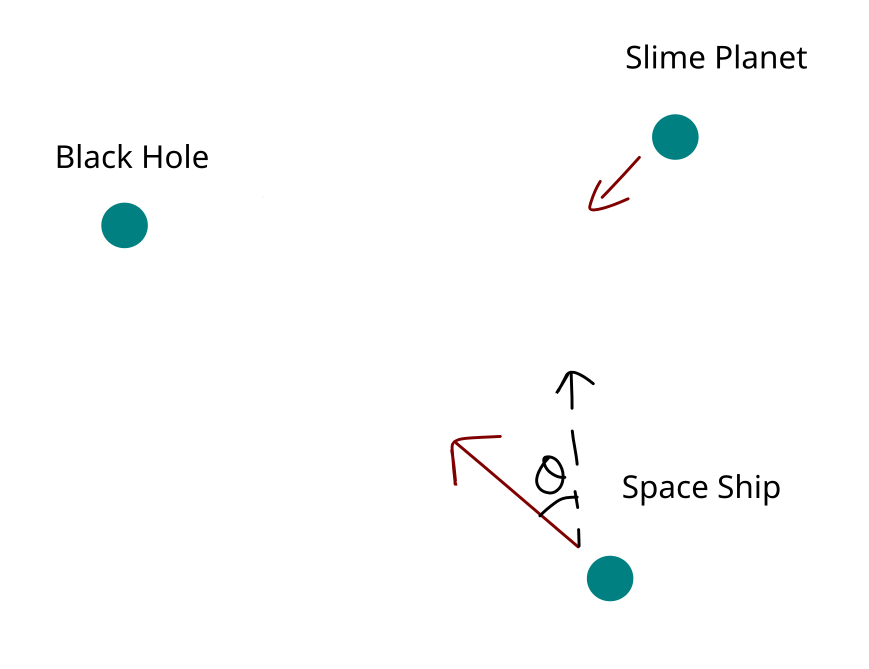

(although, not to scale). *Note to self: remove the figure above! Not to end up in the final draft!!*

*TODO: ADD SECTION ON REALISTIC APPROXIMATIONS FOR THE FOLLOWING INITIAL VALUES:*

In [ ]:
black_hole = RigidBody(
    initial_position=(0,0),
    mass=100
)

space_ship = Spaceship(
    initial_position=(1,-1),
    initial_velocity=()
    remaining_fuel_mass=100
)

slime_planet = SoftBody(
    radius          = 0,
    stiffness       = 0,
    growth_exponent = 3/2,
    damping_coeff   = 0
)

In [ ]:
simulate_all(black_hole, space_ship, slime_planet, 
             angle_range=(-np.pi/2, np.pi/2),
             speed_range=(100,1000),
             time_range=(0, 100), dt=0.01)

### Bibliography

[1] https://en.wikipedia.org/wiki/Specific_impulse

[2] https://en.wikipedia.org/wiki/Standard_gravity